# Multi-Agent-Foundation-Model-Functioning-Demo

Multi-Agent functioning is a system where multiple foundation models each specilized in particular task cordinate together to solve complex tasks.

We are using three agents:
- Agent for sentiment analysis
- Agent for Question Answering
- Agent for image captioning.

In [27]:
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    pipeline,
    VisionEncoderDecoderModel,
    ViTFeatureExtractor
)
from PIL import Image
import requests
import os
from typing import Dict, List, Any, Tuple
import numpy as np

In [28]:
class BaseAgent:
    def __init__(self, name: str):
        self.name = name          # Unique identifier for the agent
        self.memory = []          # Store history of processed tasks

    def process(self, input_data: Any) -> Dict:
        raise NotImplementedError  # Must be implemented by child classes

    def log_result(self, input_data: Any, output: Any):
        self.memory.append({"input": input_data, "output": output})  # Log for history

In [29]:
class SentimentAgent(BaseAgent):
    def __init__(self):
        super().__init__("sentiment_agent")
        # Load BERT model fine-tuned for sentiment analysis
        self.tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "nlptown/bert-base-multilingual-uncased-sentiment"
        )
        self.sentiment_pipeline = pipeline(
            "sentiment-analysis",
            model=self.model,
            tokenizer=self.tokenizer
        )

    def process(self, text: str) -> Dict:
        result = self.sentiment_pipeline(text)[0]
        self.log_result(text, result)
        return {
            "agent": self.name,
            "confidence": float(result["score"]),
            "sentiment": result["label"],
            "raw_text": text
        }

In [30]:
class QAAgent(BaseAgent):
    def __init__(self):
        super().__init__("qa_agent")
        # Load BERT model fine-tuned for question answering
        model_name = "deepset/roberta-base-squad2"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_name)
        self.qa_pipeline = pipeline(
            "question-answering",
            model=self.model,
            tokenizer=self.tokenizer
        )

    def process(self, query: Dict) -> Dict:
        result = self.qa_pipeline({
            "question": query["question"],
            "context": query["context"]
        })
        self.log_result(query, result)
        return {
            "agent": self.name,
            "answer": result["answer"],
            "confidence": float(result["score"]),
            "question": query["question"]
        }

In [31]:
class VisionAgent(BaseAgent):
    def __init__(self):
        super().__init__("vision_agent")
        # Load Vision Transformer model
        self.feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

        # Set special tokens
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def process(self, image_path: str) -> Dict:
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Prepare image features
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values

        # Generate caption with attention mask
        with torch.no_grad():
            # Create attention mask
            attention_mask = torch.ones(pixel_values.shape[0], pixel_values.shape[1])

            output_ids = self.model.generate(
                pixel_values,
                attention_mask=attention_mask,
                max_length=16,
                num_beams=4,
                return_dict_in_generate=True,
                output_scores=True  # Enable output scores
            )

        # Decode caption
        caption = self.tokenizer.batch_decode(output_ids.sequences, skip_special_tokens=True)[0]

        # Calculate confidence using mean prediction scores
        scores = torch.stack(output_ids.scores, dim=1)
        confidence = float(torch.mean(torch.max(torch.softmax(scores, dim=-1), dim=-1)[0]).item())

        self.log_result(image_path, caption)
        return {
            "agent": self.name,
            "caption": caption,
            "confidence": confidence,
            "image_path": image_path
        }

Multi-Agent Working.....
- Here first Vision model creates caption of the image.
- The caption is provided to SentimentAgent which retunrs the sentimental rating with the corresponding confidence score.
- The caption is also passed to QAAgent and returns the answer for the provided question.

In [32]:
class Coordinator:
    def __init__(self):
        self.agents = {
            "sentiment": SentimentAgent(),
            "qa": QAAgent(),
            "vision": VisionAgent()
        }
        self.task_history = []

    def process_task(self, task_type: str, input_data: Any) -> Dict:
        """Process a task using the appropriate agent"""
        if task_type not in self.agents:
            raise ValueError(f"Unknown task type: {task_type}")

        result = self.agents[task_type].process(input_data)
        self.task_history.append({
            "task_type": task_type,
            "input": input_data,
            "result": result
        })
        return result

    def process_multimodal_task(self, image_path: str, text: str, question: str) -> Dict:
        """Process a task that requires multiple agents"""
        # Get image caption
        vision_result = self.agents["vision"].process(image_path)

        # Analyze sentiment of both the caption and provided text
        sentiment_caption = self.agents["sentiment"].process(vision_result["caption"])
        sentiment_text = self.agents["sentiment"].process(text)
        qa_caption = self.agents["qa"].process({
            "context": vision_result["caption"],
            "question": question
        })

        combined_result = {
            "image_analysis": vision_result,
            "caption_sentiment": sentiment_caption,
            "text_sentiment": sentiment_text,
            "qa_caption": qa_caption,
            # "qa_text": qa_text,
            "overall_confidence": np.mean([
                vision_result["confidence"],
                sentiment_caption["confidence"],
                sentiment_text["confidence"],
                qa_caption["confidence"],
                # qa_text["confidence"]
            ])
        }

        self.task_history.append({
            "task_type": "multimodal",
            "input": {"image": image_path, "text": text, "question": question},
            "result": combined_result
        })

        return combined_result



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared


Processing sentiment analysis...
Sentiment Result: {'agent': 'sentiment_agent', 'confidence': 0.9295662045478821, 'sentiment': '5 stars', 'raw_text': 'This dog brings so much joy and happiness to everyone at the park!'}

Processing question answering...
QA Result: {'agent': 'qa_agent', 'answer': 'sunny park', 'confidence': 0.2783358097076416, 'question': 'Where is the dog playing?'}

Processing vision analysis...
Vision Result: {'agent': 'vision_agent', 'caption': 'a dog running in a field with a frisbee in its mouth ', 'confidence': 0.7111971378326416, 'image_path': 'sample_image.jpg'}

Processing multimodal analysis...
Multimodal Result: {'image_analysis': {'agent': 'vision_agent', 'caption': 'a dog running in a field with a frisbee in its mouth ', 'confidence': 0.7111971378326416, 'image_path': 'sample_image.jpg'}, 'caption_sentiment': {'agent': 'sentiment_agent', 'confidence': 0.33877843618392944, 'sentiment': '4 stars', 'raw_text': 'a dog running in a field with a frisbee in its 

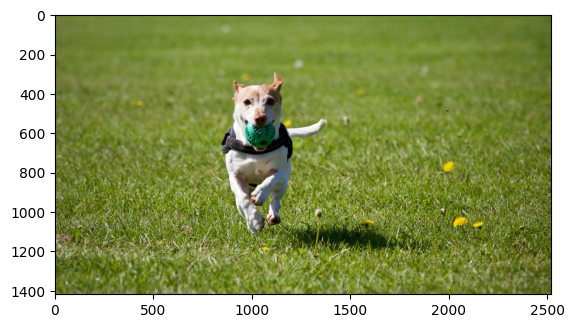

In [33]:
def main():
    # Initialize the coordinator
    coordinator = Coordinator()


    # Example 1: Sentiment Analysis
    print("\nProcessing sentiment analysis...")
    sentiment_result = coordinator.process_task(
        "sentiment",
        "This dog brings so much joy and happiness to everyone at the park!"
    )
    print(f"Sentiment Result: {sentiment_result}")

    # Example 2: Question Answering
    print("\nProcessing question answering...")
    qa_result = coordinator.process_task(
        "qa",
        {
            "question": "Where is the dog playing?",
            "context": "The energetic dog is having a wonderful time playing fetch in the sunny park. Many people stop to watch the happy dog running around."
        }
    )
    print(f"QA Result: {qa_result}")

    # Example 3: Vision Analysis (requires an image file)
    print("\nProcessing vision analysis...")
    try:
        # Download a sample image
        # image_url = "https://camo.githubusercontent.com/68d76220a06ab05bef0a7f6663f02a3ff3eae4c492a10640077fa071d2538ebe/68747470733a2f2f68756767696e67666163652e636f2f64617461736574732f68756767696e67666163652f646f63756d656e746174696f6e2d696d616765732f7265736f6c76652f6d61696e2f7472616e73666f726d6572732f6d6f64656c5f646f632f7669745f6172636869746563747572652e6a7067"
        image_url="https://images.pexels.com/photos/422220/pexels-photo-422220.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"
        image_path = "sample_image.jpg"
        response = requests.get(image_url)
        with open(image_path, "wb") as f:
            f.write(response.content)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        vision_result = coordinator.process_task("vision", image_path)
        print(f"Vision Result: {vision_result}")

        # Example 4: Multimodal Analysis
        print("\nProcessing multimodal analysis...")
        multimodal_result = coordinator.process_multimodal_task(
            image_path,
            "The dog's playful energy makes everyone at the park smile!",
            "what is the topic described?"
        )
        print(f"Multimodal Result: {multimodal_result}")

        # Cleanup
        # os.remove(image_path)

    except Exception as e:
        print(f"Error processing vision tasks: {str(e)}")

if __name__ == "__main__":
    main()